In [ ]:
%tensorflow_version 1.x
import keras
from keras import backend as K
from keras.layers import Layer
from keras.initializers import Constant
import numpy as np
import os

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
os.getcwd()

'/content'

In [ ]:
class WindowLevelLayer(Layer):
  def __init__(self, output_dim, window, level, **kwargs):
    self.output_dim = output_dim
    self.startWindow = window
    self.startLevel = level
    super(WindowLevelLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.WLc1 = self.add_weight(name="windowLevel_c1",
                                  shape=(2,),
                                  initializer='uniform',
                                  trainable=True)
    self.WLc2 = self.add_weight(name="windowLevel_c2",
                                  shape=(2,),
                                  initializer='uniform',
                                  trainable=True)
    self.WLc3 = self.add_weight(name="windowLevel_c3",
                                  shape=(2,),
                                  initializer='uniform',
                                  trainable=True)

    self.set_weights( [np.array([ self.startWindow[0], self.startLevel[0] ] ),
                       np.array([ self.startWindow[1], self.startLevel[1] ] ),
                       np.array([ self.startWindow[2], self.startLevel[2] ])
                     ])
    super(WindowLevelLayer, self).build(input_shape)


  def call(self, x):
    minval_1 = K.ones_like(x) * (self.WLc1[1] - self.WLc1[0]/2)
    maxval_1 = K.ones_like(x) * (self.WLc1[1] + self.WLc1[0]/2)
    c1 = ( (K.minimum(K.maximum(x, minval_1), maxval_1) - minval_1) / (maxval_1 - minval_1) )*255

    minval_2 = K.ones_like(x) * (self.WLc2[1] - self.WLc2[0]/2)
    maxval_2 = K.ones_like(x) * (self.WLc2[1] + self.WLc2[0]/2)
    c2 = ((K.minimum(K.maximum(x, minval_2), maxval_2)  - minval_2)/ (maxval_2 - minval_2)   )*255

    minval_3 = K.ones_like(x) * (self.WLc3[1] - self.WLc3[0]/2)
    maxval_3 = K.ones_like(x) * (self.WLc3[1] + self.WLc3[0]/2)
    c3 = ((K.minimum(K.maximum(x, minval_3), maxval_3)  - minval_3)/ (maxval_3 - minval_3)   )*255


    return K.concatenate([c1,c2,c3], axis=-1)

  def compute_output_shape(self, input_shape):
    return (*input_shape[:-1], 3)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, UpSampling2D
from keras.models import Model

#from WindowLevelLayer import WindowLevelLayer

In [ ]:
def buildModel(vggWeightsPath=None, classes=4, freezeVGGLayers=True, wllayer=False, wlSpec=None):
    activ = 'relu'
    ## Add our new W/L layer to the model to go from 1 channel to 3
    if wllayer:
      inputLayer = Input(name="input_1", shape=(512,512,1))
      if wlSpec is None:
        rgb_ified = WindowLevelLayer(1, [600, 1600, 700], [1070, 1800, 960], input_shape=(512,512,1))(inputLayer)
      else:
        rgb_ified = WindowLevelLayer(1, wlSpec[0,:], wlSpec[1,:], input_shape=(512,512,1))(inputLayer)

      b1_c1 = Conv2D(64, (3,3), name="block1_conv1", padding='same', activation=activ)(rgb_ified)
    else:
      inputLayer = Input(name="input_1", shape=(512,512,3))
      b1_c1 = Conv2D(64, (3,3), name="block1_conv1", padding='same', activation=activ)(inputLayer)

    b1_c2 = Conv2D(64, (3,3), name="block1_conv2", padding='same', activation=activ)(b1_c1) ## Skip connection 1 from here
    b1_pool = MaxPooling2D(name="block1_pool")(b1_c2)

    b2_c1 = Conv2D(128, (3,3), name="block2_conv1", padding='same', activation=activ)(b1_pool)
    b2_c2 = Conv2D(128, (3,3), name="block2_conv2", padding='same', activation=activ)(b2_c1) ## Skip connection 2 from here
    b2_pool = MaxPooling2D(name="block2_pool")(b2_c2)

    b3_c1 = Conv2D(256, (3,3), name="block3_conv1", padding='same', activation=activ)(b2_pool)
    b3_c2 = Conv2D(256, (3,3), name="block3_conv2", padding='same', activation=activ)(b3_c1) ## Skip connection 3 from here
    b3_pool = MaxPooling2D(name="block3_pool")(b3_c2)

    b4_c1 = Conv2D(512, (3,3), name="block4_conv1", padding='same', activation=activ)(b3_pool)
    b4_c2 = Conv2D(512, (3,3), name="block4_conv2", padding='same', activation=activ)(b4_c1) ## Skip connection 4 from here
    b4_pool = MaxPooling2D(name="block4_pool")(b4_c2)

    b5_c1 = Conv2D(1024, (3,3), name="nblock5_conv1", padding='same', activation=activ)(b4_pool)
    b5_tc1 = UpSampling2D((2,2))(b5_c1)
    b5_tc1 = Conv2D(512, (3,3), strides=(1,1), padding='same')(b5_tc1)
    b5_bn = BatchNormalization()(b5_tc1)

    sk4 = Concatenate(name="skip4")([b4_c2, b5_bn])

    nb4_c1 = Conv2D(512, (3,3), name="nblock4_conv1", padding='same', activation=activ)(sk4)
    nb4_c2 = Conv2D(512, (3,3), name="nblock4_conv2", padding='same', activation=activ)(nb4_c1)
    nb4_tc1 = UpSampling2D((2,2))(nb4_c2)
    nb4_tc1 = Conv2D(256, (3,3), strides=(1,1), padding='same', name="nblock4_tconv1")(nb4_tc1)
    b4_bn = BatchNormalization()(nb4_tc1)

    sk3 = Concatenate(name="skip3")([b3_c2, b4_bn])

    nb3_c1 = Conv2D(256, (3,3), name="nblock3_conv1", padding='same', activation=activ)(sk3)
    nb3_c2 = Conv2D(256, (3,3), name="nblock3_conv2", padding='same', activation=activ)(nb3_c1)
    nb3_tc1 = UpSampling2D((2,2))(nb3_c2)
    nb3_tc1 = Conv2D(128, (3,3), strides=(1,1), padding='same', name="nblock3_tconv1")(nb3_tc1)
    b3_bn = BatchNormalization()(nb3_tc1)

    sk2 = Concatenate(name="skip2")([b2_c2, b3_bn])

    nb2_c1 = Conv2D(128, (3,3), name="nblock2_conv1", padding='same', activation=activ)(sk2)
    nb2_c2 = Conv2D(128, (3,3), name="nblock2_conv2", padding='same', activation=activ)(nb2_c1)
    nb2_tc1 = UpSampling2D((2,2))(nb2_c2)
    nb2_tc1 = Conv2D(64, (3,3), strides=(1,1), padding='same', name="nblock2_tconv1")(nb2_tc1)
    b2_bn = BatchNormalization()(nb2_tc1)
    sk1 = Concatenate(name="skip1")([b1_c2, b2_bn])

    scoreConv1 = Conv2D(64, (3,3), padding='same', name="score_conv1", activation=activ)(sk1)
    bf_bn = BatchNormalization()(scoreConv1)
    finalConv = Conv2D(classes, (3,3), padding='same', name="output_conv", activation='softmax')(bf_bn)

    model = Model(inputs=[inputLayer], outputs=[finalConv])

    if vggWeightsPath is not None:
        model.load_weights(vggWeightsPath, by_name=True)

    if freezeVGGLayers:
        for layer in model.layers[:14]:
            layer.trainable=False
    return model



In [ ]:
## test code
'''
if __name__ == "__main__":
  vggWeightsFile = "/content/drive/My Drive/MPHYS/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
  model = buildModel(vggWeightsFile)

  print(model.summary())
'''

'\nif __name__ == "__main__":\n  vggWeightsFile = "/content/drive/My Drive/MPHYS/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"\n  model = buildModel(vggWeightsFile)\n\n  print(model.summary())\n'

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD

In [ ]:
import numpy as np
import json
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

In [ ]:
vggWeightsFile = "/content/drive/My Drive/MPHYS/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
def logitLossFunction(tgt, logits):
    logits_flat = K.reshape(logits, [-1, 4])
    tgt_flat = K.reshape(tgt, [-1,4])
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_flat, labels=tgt_flat))

def focalLogitLossFunction(tgt, logits, gamma=2):
    logits_flat = K.reshape(logits, [-1, 4])
    tgt_flat = K.reshape(tgt, [-1,4])
    L = -tgt_flat*((1-logits_flat)**gamma)*tf.log(logits_flat)
    return tf.reduce_sum(L, axis=1)

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def multiclass_dice(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true[...,1:]) ## ignore background
    y_pred_f = K.flatten(y_pred[...,1:])
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersection / (denom + smooth)))

def multiclass_dice_loss(y_true, y_pred):
    return 1 - multiclass_dice(y_true, y_pred)

In [ ]:
training = True

In [ ]:
slicesPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPScansTrainStack.npy"
masksPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPMasksTrainStack.npy"

valSlicesPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPScansValStack.npy"
valMasksPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPMasksValStack.npy"

testSlicesPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPScansTestStack.npy"
testMasksPath = "/content/drive/My Drive/MPHYS/NEW_NPYStacks/NPMasksTestStack.npy"

In [ ]:
from keras.utils import to_categorical

slices = np.load(slicesPath)
masks = to_categorical(np.load(masksPath))

valSlices = np.load(valSlicesPath)
valMasks = to_categorical(np.load(valMasksPath))

testSlices = np.load(testSlicesPath)
testMasks = to_categorical(np.load(testMasksPath))


In [ ]:
wlspec = np.array([[600, 1600, 700], [1070, 1800, 960]])
wlspecminus = np.array([[600, 1600, 700], [46, 776, -64]])
wlspecMinusNew = np.array([[200, 507, 700], [-18, -36, -250]])

In [ ]:
datagen = ImageDataGenerator(rotation_range=5, zoom_range=0.1, horizontal_flip=False, fill_mode='nearest')
maskgen = ImageDataGenerator(rotation_range=5, zoom_range=0.1, horizontal_flip=False, fill_mode='nearest')

In [ ]:
valsgen = ImageDataGenerator()
valmgen = ImageDataGenerator()

In [ ]:
seed = 1234
sliceGenerator = datagen.flow(slices,  seed=seed, batch_size=2)#, save_to_dir="./augImages")
maskGenerator = maskgen.flow(masks,  seed=seed, batch_size=2)#, save_to_dir="./augMasks")

# reduced batch size because of Resource exhausted: OOM when allocating tensor with shape[4,128,512,512] error

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (61, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
valSliceGenerator = valsgen.flow(valSlices[:], seed=seed+1, batch_size=1)
valMaskGenerator  = valmgen.flow(valMasks[:], seed=seed+1, batch_size=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
train_generator = zip(sliceGenerator, maskGenerator)
val_generator = zip(valSliceGenerator, valMaskGenerator)

In [ ]:
model = buildModel(vggWeightsFile, classes=2, freezeVGGLayers=True, wllayer=True, wlSpec=wlspecMinusNew)

In [ ]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
window_level_layer_4 (WindowLev (None, 512, 512, 3)  6           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        window_level_layer_4[0][0]       
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
____________________________________________________________________________________________

In [ ]:
ftOpt = Adam(lr=0.001)
model.compile(optimizer=Adam(lr=0.01), loss=dice_coef)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


NameError: ignored

In [ ]:
! mkdir logs && mkdir log\s/01
logdir = "./logs/01/"

In [ ]:
logging = TensorBoard(log_dir=logdir)
checkpoint = ModelCheckpoint(logdir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [ ]:
if training:
    history_initial = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, validation_data=val_generator, validation_steps=6, callbacks=[checkpoint, reduce_lr, early_stopping])

    ## at thins point, maybe make some layers trainable again?
    modelJSON = model.to_json()
    with open("vgg16_UNet_tf.json", 'w') as mjsn:
        mjsn.write(modelJSON)
    model.save_weights("vgg16_UNet_4class_stage1_dsc_tf.h5")

    for i in range(len(model.layers)):
            model.layers[i].trainable = True

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss)
    print(model.summary())
    history_main = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=6, initial_epoch=10, callbacks=[checkpoint, reduce_lr, early_stopping])
    model.save_weights("vgg16_UNet_4class_stage2_dsc_tf.h5")
else:
    model.load_weights("/content/drive/My Drive/MPHYS/CNNFILES/vgg16_UNet_4class.h5")

Epoch 1/10
100/100 [==============================] - 27s 272ms/step - loss: 0.4188 - val_loss: 0.3794
Epoch 2/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3546 - val_loss: 0.3545
Epoch 3/10
100/100 [==============================] - 25s 253ms/step - loss: 0.3470 - val_loss: 0.3585
Epoch 4/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3391 - val_loss: 0.3499
Epoch 5/10
100/100 [==============================] - 25s 251ms/step - loss: 0.3369 - val_loss: 0.3494
Epoch 6/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3364 - val_loss: 0.3351
Epoch 7/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3358 - val_loss: 0.3550
Epoch 8/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3356 - val_loss: 0.3389
Epoch 9/10
100/100 [==============================] - 25s 251ms/step - loss: 0.3355 - val_loss: 0.3367

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776

In [ ]:
print(history_initial.history.keys())
print(history_main.history.keys())

dict_keys(['val_loss', 'loss', 'lr'])
dict_keys(['val_loss', 'loss', 'lr'])


In [ ]:
val_loss = np.concatenate((history_initial.history['val_loss'], history_main.history['val_loss']))
loss = np.concatenate((history_initial.history['loss'], history_main.history['loss']))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
%matplotlib inline

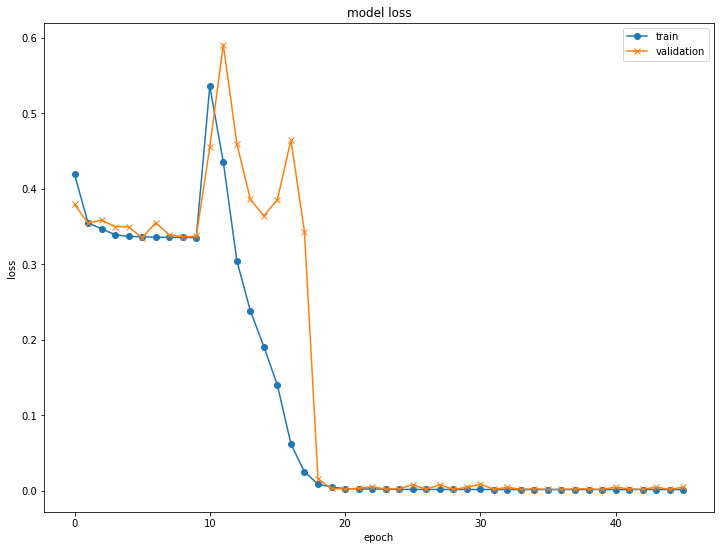

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(loss, marker = 'o')
ax.plot(val_loss, marker = 'x')
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'validation'], loc='upper right')
fig.savefig('/content/NewAttemptLoss')

In [ ]:
WeightsFile = '/content/drive/My Drive/MPHYS/vgg16_UNet_final_weights.h5'
model = buildModel(WeightsFile, classes=2, freezeVGGLayers=True, wllayer=True, wlSpec=wlspecMinusNew)
model.compile(optimizer="Adam", loss = dice_coef_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.load_weights(WeightsFile)

In [ ]:
results = model.evaluate(testSlices[0][np.newaxis,:,:,:], testMasks[0][np.newaxis,:,:,:], batch_size=1)
print('test loss:', results)


1/1 [==============================] - 11s 11s/step
test loss: 0.0015333091141656041


In [ ]:
dice = []
for i in range(0,6):
  results = model.evaluate(testSlices[i][np.newaxis,:,:,:], testMasks[i][np.newaxis,:,:,:], batch_size=1)
  print('test loss:', results)
  dice.append(results)

1/1 [==============================] - 1s 775ms/step
test loss: 0.0015333091141656041
1/1 [==============================] - 1s 679ms/step
test loss: 0.005295468959957361
1/1 [==============================] - 1s 717ms/step
test loss: 0.0022258739918470383
1/1 [==============================] - 1s 680ms/step
test loss: 0.0023454793263226748
1/1 [==============================] - 1s 708ms/step
test loss: 0.0059873806312680244
1/1 [==============================] - 1s 723ms/step
test loss: 0.0017778126057237387


In [ ]:
print(np.mean(dice))
print(np.std(dice))

0.003194220771547407
0.0017625683487308887


In [ ]:
n = 0
m = 1

In [ ]:
print('\n# Generate predictions for 1 sample')
predictions = model.predict(testSlices[n:m])
print('predictions shape:', predictions.shape)


# Generate predictions for 1 sample
predictions shape: (1, 512, 512, 2)


In [ ]:
predictions_squeezed = np.squeeze(predictions)

In [ ]:
predictions_squeezed_layer_1 = predictions_squeezed[:,:,0]
segmentation = np.argmax(predictions_squeezed, axis=-1)

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1)

ax.imshow(segmentation, cmap=plt.cm.bone)
#fig.savefig('/content/NewAttemptOutput')

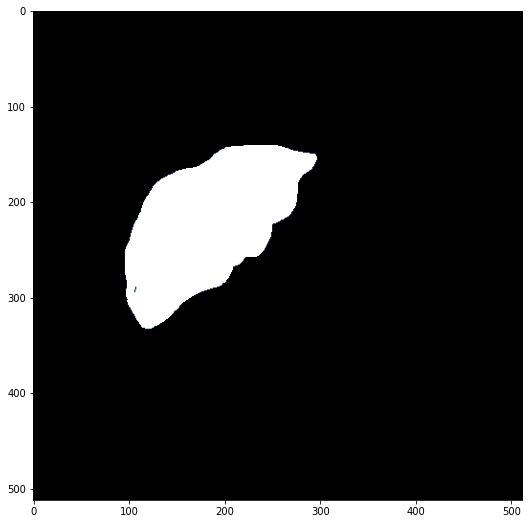

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(1, 1, 1)

ax.imshow(np.squeeze(testMasks[n:m])[:,:,1], cmap=plt.cm.bone)
#fig.savefig('/content/NewAttempt1Mask')

In [ ]:
for i in range(0, 1):
  predictions = model.predict(testSlices[i:i+1])
  predictions_squeezed = np.squeeze(predictions)
  predictions_squeezed_layer_1 = predictions_squeezed[:,:,0]
  segmentation = np.argmax(predictions_squeezed, axis=-1)
  test_mask = np.squeeze(testMasks[i:i+1])[:,:,1]

  np.save('Prediction' + str(i), segmentation)
  np.save('TestMask' + str(i), test_mask)